# 02 - Simulate user viewing logs

Goal of this notebook:

- Start from processed anime metadata:
  - `anime_master.parquet`
  - `episodes.parquet`
- Create a **synthetic user viewing log** at episode level
- Define a clear **prediction target**:
  - `label_next_episode` = 1 if user watches the next episode of the same anime
  - 0 otherwise

This will give us a realistic looking dataset for:

- Retention curves
- Drop-off behavior
- Churn style modeling

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
# Display options
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

In [3]:
# Paths
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"

In [4]:
anime_master_path = PROCESSED_DIR / "anime_master.parquet"
episodes_path = PROCESSED_DIR / "episodes.parquet"

In [5]:
print(anime_master_path)
print(episodes_path)

/Users/sanjaydilip/Desktop/Code/Projects/sim2real user engagement/anime_simulated/data/processed/anime_master.parquet
/Users/sanjaydilip/Desktop/Code/Projects/sim2real user engagement/anime_simulated/data/processed/episodes.parquet


In [6]:
anime_df = pd.read_parquet(anime_master_path)
episodes_df = pd.read_parquet(episodes_path)

In [7]:
anime_df.head()

,anime_row_id,title,type,episodes,status,season,year,duration_sec,score_mean,score_median,num_tags,num_synonyms,num_sources
0,0,!NVADE SHOW!,SPECIAL,1,FINISHED,FALL,2020.0,120.0,6.261152,6.308000,5,4,4
1,1,"""0""",SPECIAL,1,FINISHED,SUMMER,2013.0,240.0,4.906793,4.919091,7,11,9
2,2,"""1-punkan dake Furete mo Ii yo..."" Share House...",ONA,8,FINISHED,WINTER,2025.0,360.0,5.539082,5.539082,4,9,2
3,3,"""Aesop"" no Ohanashi yori: Ushi to Kaeru, Yokub...",MOVIE,1,FINISHED,WINTER,1970.0,720.0,5.220119,5.000000,6,9,9
4,4,"""Ai"" wo Taberu",MOVIE,1,FINISHED,WINTER,2018.0,480.0,NaN,NaN,3,2,3


In [8]:
episodes_df.head()

,anime_row_id,title,type,year,episode_number
0,0,!NVADE SHOW!,SPECIAL,2020.0,1
1,1,"""0""",SPECIAL,2013.0,1
2,2,"""1-punkan dake Furete mo Ii yo..."" Share House...",ONA,2025.0,1
3,2,"""1-punkan dake Furete mo Ii yo..."" Share House...",ONA,2025.0,2
4,2,"""1-punkan dake Furete mo Ii yo..."" Share House...",ONA,2025.0,3


## Filter to a reasonable subset

For simulation we do not need every single title.

To keep things simple for a first pass:

- Keep only **TV** shows
- At least 8 episodes
- Valid `year`

In [9]:
sim_anime_df = (
    anime_df
    .query("type == 'TV'")
    .copy()
)

In [10]:
# Require at least 8 episodes and a valid year
sim_anime_df = sim_anime_df[
    (sim_anime_df["episodes"].fillna(0).astype(int) >= 8)
    & (~sim_anime_df["year"].isna())
].copy()

In [11]:
sim_anime_df["episodes"] = sim_anime_df["episodes"].astype(int)
sim_anime_df["year"] = sim_anime_df["year"].astype(int)

In [12]:
print("Number of anime used for simulation:", len(sim_anime_df))
sim_anime_df[["anime_row_id", "title", "episodes", "year"]].head()

Number of anime used for simulation: 8816


,anime_row_id,title,episodes,year
22,22,"""Omae Gotoki ga Maou ni Kateru to Omouna"" to Y...",12,2026
33,33,#Compass 2.0: Sentou Setsuri Kaiseki System,12,2025
60,60,.hack//Roots,26,2006
61,61,.hack//Sign,26,2002
62,62,.hack//Tasogare no Udewa Densetsu,12,2003


## Define the simulated user population

We will create:

- `N_USERS` synthetic users
- Each user gets:
  - a `user_id`
  - an overall `engagement_level` in [0, 1]

`engagement_level` will make some users binge more than others.

In [13]:
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)
N_USERS = 5000

In [14]:
users_df = pd.DataFrame({
    "user_id": np.arange(1, N_USERS + 1),
    # engagement: low values churn early, high values binge more
    "engagement_level": rng.beta(a=2.0, b=2.0, size=N_USERS),
})

In [15]:
users_df.head()

,user_id,engagement_level
0,1,0.424548
1,2,0.527589
2,3,0.637180
3,4,0.517255
4,5,0.681351


## Global retention curve shape

We want a simple high level pattern:

- High chance to go from episode 1 to 2
- Gradual decay as episode number increases

Define a base curve by episode index:

- Episode 1: 0.80
- Episode 2: 0.72
- Episode 3: 0.65
- Episode 4: 0.60
- Episode 5: 0.55
- Episode 6: 0.50
- Episode 7: 0.47
- Episode 8: 0.44
- Episode 9+: flatten around 0.40

This will be modulated by each user's `engagement_level`.

In [16]:
# Base continuation probabilities by episode index (1-based)
BASE_RETENTION = {
    1: 0.80,
    2: 0.72,
    3: 0.65,
    4: 0.60,
    5: 0.55,
    6: 0.50,
    7: 0.47,
    8: 0.44,
}

In [17]:
def base_retention_prob(episode_number: int) -> float:
    if episode_number in BASE_RETENTION:
        return BASE_RETENTION[episode_number]
    # For later episodes, flatten slightly
    return 0.40

## Sampling which anime each user watches

For a first version:

- Each user watches between 1 and `MAX_SHOWS_PER_USER` anime
- Choice of anime is **weighted** by `score_mean` where available
  - Higher scored anime get picked more often

In [18]:
sim_anime_df["score_weight"] = sim_anime_df["score_mean"].fillna(
    sim_anime_df["score_mean"].median()
)

In [19]:
# Shift and clip to avoid negatives or zeros
sim_anime_df["score_weight"] = np.clip(
    sim_anime_df["score_weight"] - sim_anime_df["score_weight"].min() + 0.1,
    a_min=0.1,
    a_max=None,
)

In [20]:
sim_anime_df["score_weight"] = (
    sim_anime_df["score_weight"] / sim_anime_df["score_weight"].sum()
)

In [21]:
sim_anime_df[["anime_row_id", "title", "score_mean", "score_weight"]].head()

,anime_row_id,title,score_mean,score_weight
22,22,"""Omae Gotoki ga Maou ni Kateru to Omouna"" to Y...",NaN,0.000115
33,33,#Compass 2.0: Sentou Setsuri Kaiseki System,5.664231,0.000096
60,60,.hack//Roots,6.900946,0.000120
61,61,.hack//Sign,6.908129,0.000121
62,62,.hack//Tasogare no Udewa Densetsu,6.645395,0.000115


## Simulation logic

For each user:

1. Draw how many anime they watch, `k` in [1, MAX_SHOWS_PER_USER].
2. Sample `k` anime titles using the `score_weight`.
3. For each (user, anime):
   - Pick a random starting day within a 30 day window.
   - Simulate sequential episodes until they stop or reach max episodes for that anime.
   - At each episode:
     - Compute continuation probability:
       - base from `base_retention_prob(episode_number)`
       - scaled by user `engagement_level`
     - Draw a Bernoulli outcome to decide if they watch the **next** episode.
     - Record:
       - the current episode
       - a label `label_next_episode` showing whether they went on to the next one.

In [22]:
from datetime import datetime, timedelta
MAX_SHOWS_PER_USER = 5
SIMULATION_DAYS = 30

In [23]:
def simulate_user_viewing_logs(
    users_df: pd.DataFrame,
    anime_df: pd.DataFrame,
    rng: np.random.Generator,
) -> pd.DataFrame:
    logs = []
    anime_values = anime_df[["anime_row_id", "title", "episodes", "score_weight"]].to_numpy()
    anime_weights = anime_values[:, -1].astype(float)
    start_date = datetime(2024, 1, 1)
    for user in users_df.itertuples(index=False):
        # how many anime this user starts
        k = rng.integers(1, MAX_SHOWS_PER_USER + 1)
        # sample k anime without replacement, weighted by score_weight
        chosen_idx = rng.choice(
            anime_values.shape[0],
            size=min(k, anime_values.shape[0]),
            replace=False,
            p=anime_weights,
        )
        for idx in chosen_idx:
            anime_row_id, title, n_eps, _w = anime_values[idx]
            n_eps = int(n_eps)
            # random starting day for this anime
            start_day_offset = int(rng.integers(0, SIMULATION_DAYS))
            watch_start_time = start_date + timedelta(days=start_day_offset)
            # simulate sequential episodes for this anime
            episode_number = 1
            # we cap the number of episodes to avoid very long runs
            MAX_EPISODES_FOR_ANIME = min(n_eps, 48)
            while episode_number <= MAX_EPISODES_FOR_ANIME:
                base_p = base_retention_prob(episode_number)
                # engagement adjustment: factor between about 0.6 and 1.4
                engagement_factor = 0.6 + 0.8 * float(user.engagement_level)
                # small random noise
                noise = rng.normal(loc=0.0, scale=0.03)
                p_continue = base_p * engagement_factor + noise
                p_continue = float(np.clip(p_continue, 0.01, 0.99))
                # simulate watch time, using 20 min default if we do not know duration
                duration_sec_default = 20 * 60
                duration_sec = duration_sec_default
                # assume they watch a big chunk of the episode
                frac_watched = float(np.clip(rng.normal(loc=0.85, scale=0.10), 0.2, 1.0))
                watch_time_sec = int(duration_sec * frac_watched)
                # draw whether they watch the *next* episode
                continue_flag = rng.random() < p_continue
                logs.append(
                    {
                        "user_id": user.user_id,
                        "engagement_level": float(user.engagement_level),
                        "anime_row_id": int(anime_row_id),
                        "anime_title": title,
                        "episode_number": int(episode_number),
                        "watch_start_time": watch_start_time,
                        "watch_time_sec": watch_time_sec,
                        "completed_fraction": frac_watched,
                        # label: did they watch the next episode of this anime
                        "label_next_episode": int(continue_flag),
                        "p_continue": p_continue,
                    }
                )
                if not continue_flag:
                    # user stops at this episode
                    break
                # go to next episode, add some time shift
                episode_number += 1
                watch_start_time = watch_start_time + timedelta(hours=float(rng.uniform(0.5, 48.0)))
    logs_df = pd.DataFrame(logs)
    return logs_df

In [24]:
logs_df = simulate_user_viewing_logs(users_df, sim_anime_df, rng)
logs_df.head()

,user_id,engagement_level,anime_row_id,anime_title,episode_number,watch_start_time,watch_time_sec,completed_fraction,label_next_episode,p_continue
0,1,0.424548,9258,Fushigiboshi no☆Futagohime,1,2024-01-11 00:00:00.000000,1200,1.000000,1,0.752300
1,1,0.424548,9258,Fushigiboshi no☆Futagohime,2,2024-01-12 05:33:18.614273,873,0.728261,1,0.641141
2,1,0.424548,9258,Fushigiboshi no☆Futagohime,3,2024-01-12 07:19:33.763768,824,0.686921,0,0.648255
3,1,0.424548,19600,Magnerobo Ga-Keen,1,2024-01-01 00:00:00.000000,971,0.809331,1,0.779796
4,1,0.424548,19600,Magnerobo Ga-Keen,2,2024-01-02 19:40:27.893000,894,0.745706,1,0.667751


In [25]:
print("Number of logs:", len(logs_df))
print("Unique users in logs:", logs_df["user_id"].nunique())
print("Unique animes in logs:", logs_df["anime_row_id"].nunique())

Number of logs: 50703
Unique users in logs: 5000
Unique animes in logs: 7129


## Retention by episode index

We can now look at the empirical continuation probability:

- For each `episode_number`, compute the mean `label_next_episode`
- This should roughly follow the base curve but with noise

In [26]:
retention_by_episode = (
    logs_df
    .groupby("episode_number")["label_next_episode"]
    .mean()
    .reset_index()
    .sort_values("episode_number")
)

In [27]:
retention_by_episode

,episode_number,label_next_episode
0,1,0.792241
1,2,0.738691
2,3,0.692210
3,4,0.656432
4,5,0.614159
5,6,0.560313
6,7,0.587068
7,8,0.521902
8,9,0.502415
9,10,0.466346


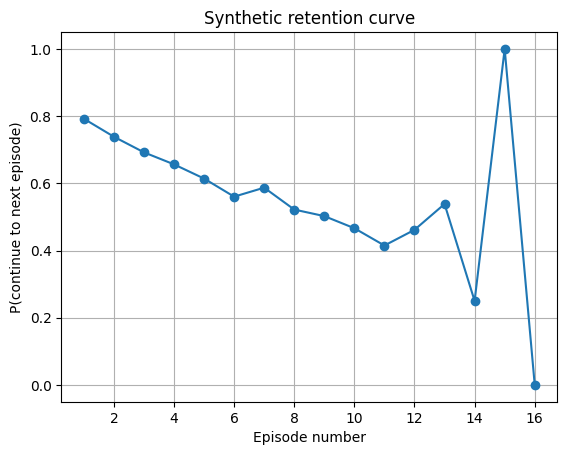

In [28]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(
    retention_by_episode["episode_number"],
    retention_by_episode["label_next_episode"],
    marker="o",
)
plt.xlabel("Episode number")
plt.ylabel("P(continue to next episode)")
plt.title("Synthetic retention curve")
plt.grid(True)
plt.show()

## Simple user and show level stats

- How many episodes does a typical user watch in total?
- How many episodes per anime per user?

In [29]:
user_episode_counts = (
    logs_df.groupby("user_id")["episode_number"]
    .count()
    .rename("episodes_watched")
    .reset_index()
)

In [30]:
user_episode_counts["episodes_watched"].describe()

count    5000.000000
mean       10.140600
std         6.712395
min         1.000000
25%         5.000000
50%         9.000000
75%        14.000000
max        41.000000
Name: episodes_watched, dtype: float64

In [31]:
per_user_anime_depth = (
    logs_df.groupby(["user_id", "anime_row_id"])["episode_number"]
    .max()
    .rename("max_episode_watched")
    .reset_index()
)

In [32]:
per_user_anime_depth["max_episode_watched"].describe()

count    14873.000000
mean         3.409063
std          2.160412
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         16.000000
Name: max_episode_watched, dtype: float64

## Save the viewing logs

We save the synthetic log as a parquet file for downstream work.

This will be the main dataset for:

- Retention curves
- Cohorts
- ML models to predict `label_next_episode`

In [33]:
viewing_logs_path = PROCESSED_DIR / "viewing_logs.parquet"
logs_df.to_parquet(viewing_logs_path, index=False)

In [34]:
viewing_logs_path

PosixPath('/Users/sanjaydilip/Desktop/Code/Projects/sim2real user engagement/anime_simulated/data/processed/viewing_logs.parquet')

## Summary

In this notebook we:

- Loaded `anime_master.parquet` and `episodes.parquet`
- Filtered to a subset of TV anime for simulation
- Created a synthetic user population with an `engagement_level`
- Defined a simple global retention curve and modulated it per user
- Simulated episode by episode viewing, logging:
  - `user_id`, `anime_row_id`, `anime_title`
  - `episode_number`, `watch_start_time`, `watch_time_sec`, `completed_fraction`
  - `label_next_episode` and `p_continue`
- Saved the final log to `data/processed/viewing_logs.parquet`

This dataset is now ready for:

- A **retention and cohort analysis** notebook
- A **first ML model** that predicts `label_next_episode` from user, anime, and episode features